In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problems.high_dimension_problems import MengCase1
from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
# fix the random seed for reproducibility
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# define function
func = MengCase1(noise_std=0.0)
# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
# hf_samples = lf_samples[::10]  # sample every 5 points
hf_samples = torch.linspace(0, 1, 11).reshape(-1, 1)
# add the end points
# hf_samples = torch.cat(
#     [torch.tensor([[0.0]]), hf_samples, torch.tensor([[0.93]]), torch.tensor([[0.975,]]), torch.tensor([[1.0]])], dim=0)

# generate responses
lf1_responses = func.lf1(lf_samples, noise_lf=0.05)
lf2_responses = func.lf2(lf_samples, noise_lf=0.05)
lf3_responses = func.lf3(lf_samples, noise_lf=0.05)
# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.05)

In [3]:
# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

# dataset of lf1 and hf
responses_lf1 = {"lf": lf1_responses,
                 "hf": hf_responses}
# dataset of lf2 and hf
responses_lf2 = {"lf": lf2_responses,
                 "hf": hf_responses}
# dataset of lf2 and hf
responses_lf3 = {"lf": lf3_responses,
                 "hf": hf_responses}

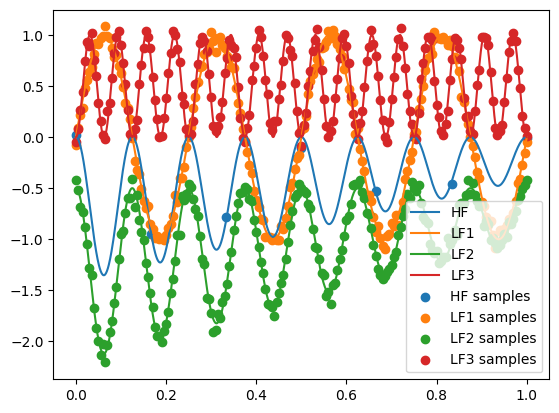

In [4]:
# generate the test points
test_samples = torch.linspace(0, 1, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf1_responses_noiseless = func.lf1(test_samples, noise_lf=0.0)
test_lf2_responses_noiseless = func.lf2(test_samples, noise_lf=0.0)
test_lf3_responses_noiseless = func.lf3(test_samples, noise_lf=0.0)
# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.05)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf1_responses_noiseless, label="LF1")
ax.plot(test_samples, test_lf2_responses_noiseless, label="LF2")
ax.plot(test_samples, test_lf3_responses_noiseless, label="LF3")

# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf1_responses, label="LF1 samples")
ax.scatter(lf_samples, lf2_responses, label="LF2 samples")
ax.scatter(lf_samples, lf3_responses, label="LF3 samples")
plt.legend()
plt.show()

In [5]:
# correlation between HF and LF samples
print("Correlation between HF and LF samples")
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf1_responses_noiseless.flatten()))
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf2_responses_noiseless.flatten()))
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf3_responses_noiseless.flatten()))

Correlation between HF and LF samples
PearsonRResult(statistic=-0.10188644911515204, pvalue=0.0012469444921648742)
PearsonRResult(statistic=0.9999999999999968, pvalue=0.0)
PearsonRResult(statistic=-0.0017524097403948545, pvalue=0.9558400867481446)


## Configurations for DNN and BNNs


In [6]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [40, 40],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [40, 40],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 20000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 10000,
}

### train standard BNN using HF data


In [7]:
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses.clone() -
                       hf_responses_mean) / hf_responses_std

# create the sf_bnn model
sigma_scale = float(0.05 / hf_responses_std)
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[40, 40],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)
# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses_scaled,
    num_epochs=20000,
    sample_freq=100,
    burn_in_epochs=10000,
)

C:\Users\yaga\GitHub\mfbml\src\mfbml\methods\bnn.py:170: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1578.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:     0/20000
nll_loss: 193.201, prior_loss: 1640.126, total: 1833.327
noise: 0.130
epoch:   100/20000
nll_loss: 146.907, prior_loss: 1776.151, total: 1923.058
noise: 0.130
epoch:   200/20000
nll_loss: 121.615, prior_loss: 1839.912, total: 1961.527
noise: 0.130
epoch:   300/20000
nll_loss: 103.948, prior_loss: 1904.197, total: 2008.145
noise: 0.130
epoch:   400/20000
nll_loss: 79.767, prior_loss: 1965.836, total: 2045.604
noise: 0.130
epoch:   500/20000
nll_loss: 67.628, prior_loss: 2021.664, total: 2089.292
noise: 0.130
epoch:   600/20000
nll_loss: 55.720, prior_loss: 2076.879, total: 2132.600
noise: 0.130
epoch:   700/20000
nll_loss: 57.783, prior_loss: 2124.643, total: 2182.426
noise: 0.130
epoch:   800/20000
nll_loss: 51.829, prior_loss: 2171.933, total: 2223.762
noise: 0.130
epoch:   900/20000
nll_loss: 54.224, prior_loss: 2219.283, total: 2273.507
noise: 0.130
epoch:  1000/20000
nll_loss: 42.907, prior_loss: 2260.937, total: 2303.844
noise: 0.130
epoch:  1100/20000
nll_loss:

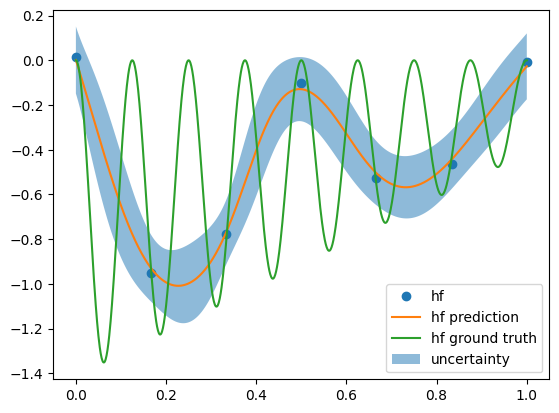

In [8]:
# visualize the posterior of bnn
(bnn_y,
 bnn_epistemic,
 bnn_total_unc,
 bnn_aleatoric) = bnn_model.predict(
    x=test_samples)
# scale the prediction
bnn_y = bnn_y * hf_responses_std + hf_responses_mean
bnn_total_unc = bnn_total_unc * hf_responses_std
bnn_epistemic = bnn_epistemic * hf_responses_std
bnn_aleatoric = bnn_aleatoric * hf_responses_std

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")
plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
plt.legend()
plt.show()

# training of sequential MF-DNN-BNN model


In [9]:
# sequential mf-bnn
smf_bnn_lf1 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.96193927526474
epoch:  200 train loss:  0.9613303542137146
epoch:  300 train loss:  0.9594322443008423
epoch:  400 train loss:  0.928529679775238
epoch:  500 train loss:  0.8843902945518494
epoch:  600 train loss:  0.7666525840759277
epoch:  700 train loss:  0.602497398853302
epoch:  800 train loss:  0.4575965404510498
epoch:  900 train loss:  0.24289999902248383
epoch:  1000 train loss:  0.021201645955443382
epoch:  1100 train loss:  0.008484261110424995
epoch:  1200 train loss:  0.006765547674149275
epoch:  1300 train loss:  0.0059675415977835655
epoch:  1400 train loss:  0.005525411572307348
epoch:  1500 train loss:  0.005218065809458494
epoch:  1600 train loss:  0.0049800025299191475
epoch:  1700 train loss:  0.004789991304278374
epoch:  1800 train loss:  0.004641341045498848
epoch:  1900 train loss:  0.004519709385931492
epoch:  2000 train loss:  0.004427651409059763
epoch:  2100 train loss:  0.0043579041957855225

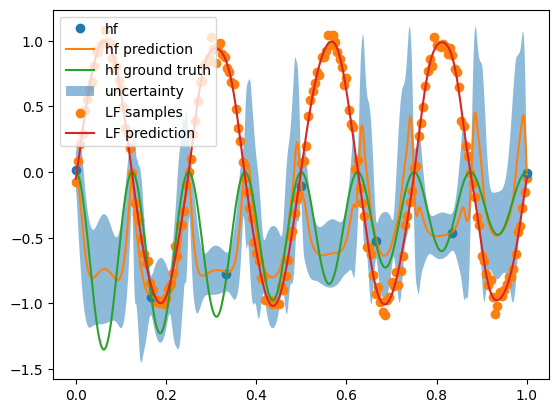

In [10]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf1_hy,
    smf_bnn_lf1_epistemic,
    smf_bnn_lf1_total_unc,
    smf_bnn_lf1_aleatoric,
) = smf_bnn_lf1.predict(x=test_samples)
# get lf predictions
smf_bnn_lf1_y = smf_bnn_lf1.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [11]:
# create the MFDNNBNN object
mfdnnbnn_lf1 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9622170329093933
epoch:  200 train loss:  0.961945116519928
epoch:  300 train loss:  0.9615501761436462
epoch:  400 train loss:  0.9594612121582031
epoch:  500 train loss:  0.9424899220466614
epoch:  600 train loss:  0.8777027130126953
epoch:  700 train loss:  0.8186628818511963
epoch:  800 train loss:  0.7467458248138428
epoch:  900 train loss:  0.5901283025741577
epoch:  1000 train loss:  0.3909793794155121
epoch:  1100 train loss:  0.2412482351064682
epoch:  1200 train loss:  0.030667992308735847
epoch:  1300 train loss:  0.010379267856478691
epoch:  1400 train loss:  0.0069335149601101875
epoch:  1500 train loss:  0.00577460927888751
epoch:  1600 train loss:  0.005342537071555853
epoch:  1700 train loss:  0.005134685896337032
epoch:  1800 train loss:  0.004999002441763878
epoch:  1900 train loss:  0.0048939744010567665
epoch:  2000 train loss:  0.0048061395063996315
epoch:  2100 train loss:  0.004729575011879206
ep

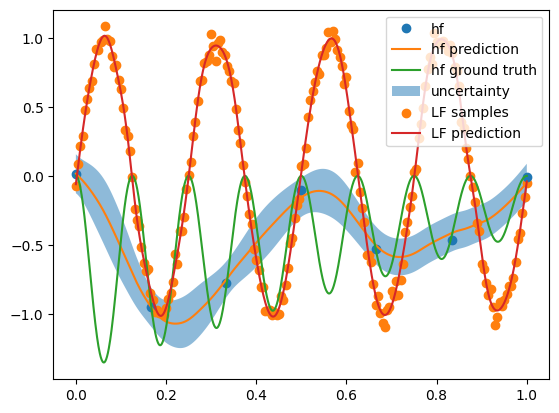

In [12]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_hy,
    mfdnnbnn_lf1_epistemic,
    mfdnnbnn_lf1_total_unc,
    mfdnnbnn_lf1_aleatoric,
) = mfdnnbnn_lf1.predict(x=test_samples)
# get lf predictions
mfdnnbnn_lf1_y = mfdnnbnn_lf1.predict_lf(x=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_y,
        label="LF prediction")
ax.legend()
plt.show()

In [13]:
# mf-dnn-bnn with different orders
mfdnnbnn_lf1_order_2 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure={
        "in_features": 1,
        "hidden_features": [50, 50],
        "out_features": 1,
        "activation": "Tanh",
        "lr": 0.01,
        "sigma": 0.05,
    },
    beta_optimize=True,
    lf_order=2,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)

# train the model
mfdnnbnn_lf1_order_2.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config={
        "num_epochs": 30000,
        "sample_freq": 100,
        "print_info": True,
        "burn_in_epochs": 20000,
    },
)

No data split: use all data for training
epoch:  100 train loss:  0.9621331691741943
epoch:  200 train loss:  0.9615896940231323
epoch:  300 train loss:  0.9607830047607422
epoch:  400 train loss:  0.9588762521743774
epoch:  500 train loss:  0.9289115071296692
epoch:  600 train loss:  0.8449265956878662
epoch:  700 train loss:  0.7397826910018921
epoch:  800 train loss:  0.5068642497062683
epoch:  900 train loss:  0.2537788450717926
epoch:  1000 train loss:  0.06381300836801529
epoch:  1100 train loss:  0.05073852837085724
epoch:  1200 train loss:  0.04452057182788849
epoch:  1300 train loss:  0.036848247051239014
epoch:  1400 train loss:  0.02663564123213291
epoch:  1500 train loss:  0.017611762508749962
epoch:  1600 train loss:  0.01269569806754589
epoch:  1700 train loss:  0.010020148009061813
epoch:  1800 train loss:  0.008292621932923794
epoch:  1900 train loss:  0.007094623055309057
epoch:  2000 train loss:  0.006271585822105408
epoch:  2100 train loss:  0.005747239571064711
epoc

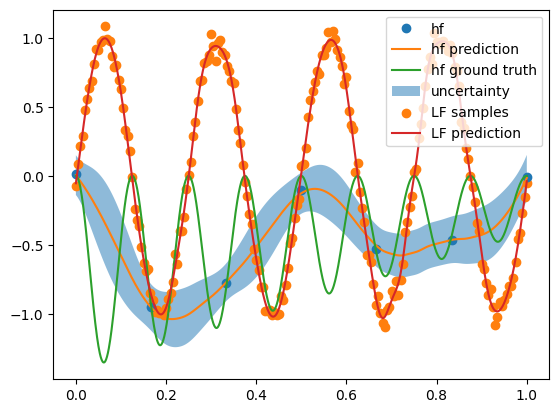

In [14]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_order_2_hy,
    mfdnnbnn_lf1_order_2_epistemic,
    mfdnnbnn_lf1_order_2_total_unc,
    mfdnnbnn_lf1_order_2_aleatoric,
) = mfdnnbnn_lf1_order_2.predict(x=test_samples)
# get lf predictions
mfdnnbnn_lf1_order_2_y = mfdnnbnn_lf1_order_2.predict_lf(
    x=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_order_2_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_order_2_hy - 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    (mfdnnbnn_lf1_order_2_hy + 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(),
        mfdnnbnn_lf1_order_2_y,
        label="LF prediction")
ax.legend()
plt.show()

In [15]:
mfdnnbnn_lf1_order_2.beta

array([-0.04497147,  0.0557163 , -0.80772215])

## mf models for the second dataset

In [16]:
# sequential mf-bnn
smf_bnn_lf2 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf2.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.8467591404914856
epoch:  200 train loss:  0.8464173078536987
epoch:  300 train loss:  0.8461816906929016
epoch:  400 train loss:  0.8460294008255005
epoch:  500 train loss:  0.8459306359291077
epoch:  600 train loss:  0.8458351492881775
epoch:  700 train loss:  0.8457105755805969
epoch:  800 train loss:  0.8455194234848022
epoch:  900 train loss:  0.8451950550079346
epoch:  1000 train loss:  0.8445613980293274
epoch:  1100 train loss:  0.8432267308235168
epoch:  1200 train loss:  0.8408263325691223
epoch:  1300 train loss:  0.8363320827484131
epoch:  1400 train loss:  0.803572952747345
epoch:  1500 train loss:  0.724007248878479
epoch:  1600 train loss:  0.6788144707679749
epoch:  1700 train loss:  0.6435471773147583
epoch:  1800 train loss:  0.5935813784599304
epoch:  1900 train loss:  0.532543957233429
epoch:  2000 train loss:  0.4644637703895569
epoch:  2100 train loss:  0.41238075494766235
epoch:  2200 train loss: 

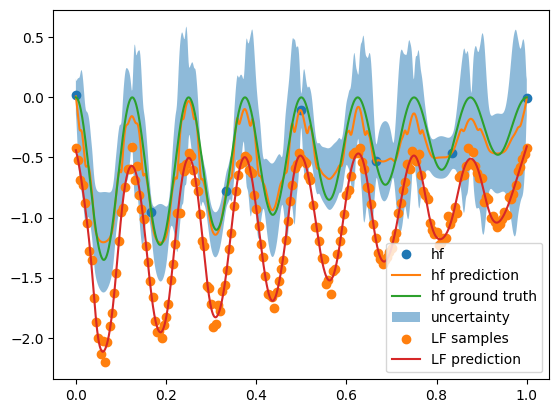

In [17]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf2_hy,
    smf_bnn_lf2_epistemic,
    smf_bnn_lf2_total_unc,
    smf_bnn_lf2_aleatoric,
) = smf_bnn_lf2.predict(x=test_samples)
# get lf predictions
smf_bnn_lf2_y = smf_bnn_lf2.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf2_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf2_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf2_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf2_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf2_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [18]:
# create the MFDNNBNN object
mfdnnbnn_lf2 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf2.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.8467442989349365
epoch:  200 train loss:  0.8464769124984741
epoch:  300 train loss:  0.8462591767311096
epoch:  400 train loss:  0.8460981845855713
epoch:  500 train loss:  0.8459867238998413
epoch:  600 train loss:  0.8459118604660034
epoch:  700 train loss:  0.8458587527275085
epoch:  800 train loss:  0.8458132743835449
epoch:  900 train loss:  0.8457663059234619
epoch:  1000 train loss:  0.8457134366035461
epoch:  1100 train loss:  0.8456531167030334
epoch:  1200 train loss:  0.8455832004547119
epoch:  1300 train loss:  0.8454993963241577
epoch:  1400 train loss:  0.8453928828239441
epoch:  1500 train loss:  0.8452451825141907
epoch:  1600 train loss:  0.8450196385383606
epoch:  1700 train loss:  0.8446483016014099
epoch:  1800 train loss:  0.8440002799034119
epoch:  1900 train loss:  0.8423835635185242
epoch:  2000 train loss:  0.8315255045890808
epoch:  2100 train loss:  0.794687807559967
epoch:  2200 train loss:

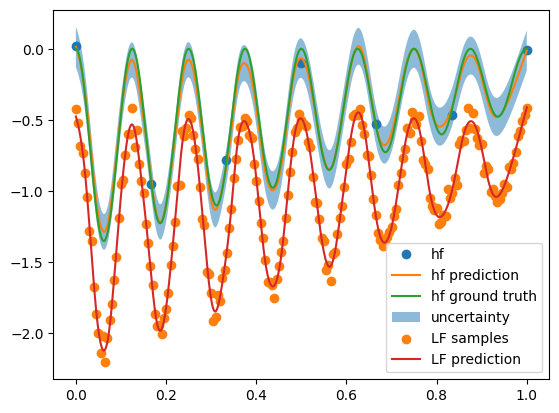

In [19]:
(
    hy_proposed_lf2,
    epistemic_proposed_lf2,
    total_unc_proposed_lf2,
    aleatoric_proposed_lf2,
) = mfdnnbnn_lf2.predict(x=test_samples)
# lf prediction
lf2_y_proposed = mfdnnbnn_lf2.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), hy_proposed_lf2, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf2 - 2 * total_unc_proposed_lf2).reshape(-1),
    (hy_proposed_lf2 + 2 * total_unc_proposed_lf2).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf2_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf2_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

## for datset 3

In [20]:
# sequential mf-bnn
smf_bnn_lf3 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf3.train(
    samples=samples,
    responses=responses_lf3,
    lf_train_config={
        "batch_size": None,
        "num_epochs": 50000,
        "print_iter": 100,
        "data_split": False,
    },
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9951223731040955
epoch:  200 train loss:  0.995038628578186
epoch:  300 train loss:  0.9949352741241455
epoch:  400 train loss:  0.9948135018348694
epoch:  500 train loss:  0.9946922063827515
epoch:  600 train loss:  0.9946150183677673
epoch:  700 train loss:  0.9945870637893677
epoch:  800 train loss:  0.9945734739303589
epoch:  900 train loss:  0.9945613145828247
epoch:  1000 train loss:  0.9945492148399353
epoch:  1100 train loss:  0.9945363402366638
epoch:  1200 train loss:  0.9945224523544312
epoch:  1300 train loss:  0.9945070147514343
epoch:  1400 train loss:  0.9944895505905151
epoch:  1500 train loss:  0.9944694638252258
epoch:  1600 train loss:  0.9944465756416321
epoch:  1700 train loss:  0.9944196939468384
epoch:  1800 train loss:  0.9943578839302063
epoch:  1900 train loss:  0.9939272403717041
epoch:  2000 train loss:  0.9937556385993958
epoch:  2100 train loss:  0.9936028718948364
epoch:  2200 train loss:

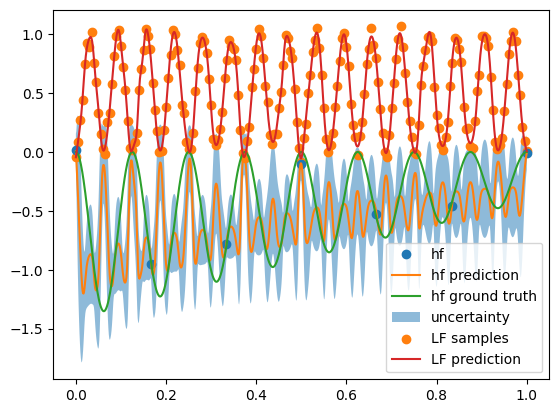

In [21]:
# plot
(
    smf_bnn_lf3_hy,
    smf_bnn_lf3_epistemic,
    smf_bnn_lf3_total_unc,
    smf_bnn_lf3_aleatoric,
) = smf_bnn_lf3.predict(x=test_samples)
# get lf predictions
smf_bnn_lf3_y = smf_bnn_lf3.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf3_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf3_hy - 2 * smf_bnn_lf3_total_unc).reshape(-1),
    (smf_bnn_lf3_hy + 2 * smf_bnn_lf3_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf3_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [22]:
# create the MFDNNBNN object
mfdnnbnn_lf3 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf3.train(
    samples=samples,
    responses=responses_lf3,
    lf_train_config={
        "batch_size": None,
        "num_epochs": 50000,
        "print_iter": 100,
        "data_split": False,
    },
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9950450658798218
epoch:  200 train loss:  0.9948616027832031
epoch:  300 train loss:  0.9947057366371155
epoch:  400 train loss:  0.994629442691803
epoch:  500 train loss:  0.9945908188819885
epoch:  600 train loss:  0.9944382905960083
epoch:  700 train loss:  0.9939761757850647
epoch:  800 train loss:  0.9931001663208008
epoch:  900 train loss:  0.9912721514701843
epoch:  1000 train loss:  0.9872984886169434
epoch:  1100 train loss:  0.9815688729286194
epoch:  1200 train loss:  0.9766994714736938
epoch:  1300 train loss:  0.9734511375427246
epoch:  1400 train loss:  0.9708887338638306
epoch:  1500 train loss:  0.9687591791152954
epoch:  1600 train loss:  0.966078519821167
epoch:  1700 train loss:  0.9622758626937866
epoch:  1800 train loss:  0.9565926194190979
epoch:  1900 train loss:  0.947730541229248
epoch:  2000 train loss:  0.9350728392601013
epoch:  2100 train loss:  0.9240426421165466
epoch:  2200 train loss:  

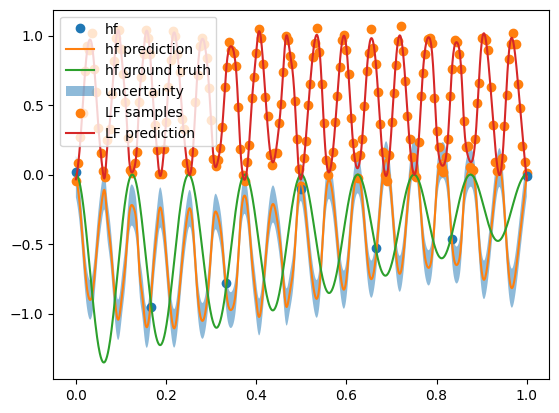

In [23]:
# predict
(
    hy_proposed_lf3,
    epistemic_proposed_lf3,
    total_unc_proposed_lf3,
    aleatoric_proposed_lf3,
) = mfdnnbnn_lf3.predict(x=test_samples)
# lf prediction
lf3_y_proposed = mfdnnbnn_lf3.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), hy_proposed_lf3, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf3 - 2 * total_unc_proposed_lf3).reshape(-1),
    (hy_proposed_lf3 + 2 * total_unc_proposed_lf3).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf3_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [24]:
# print the beta values
print("Beta values")
print(mfdnnbnn_lf1.beta)
print(mfdnnbnn_lf1_order_2.beta)
print(mfdnnbnn_lf2.beta)
print(mfdnnbnn_lf3.beta)

Beta values
[-0.40129888  0.05631723]
[-0.04497147  0.0557163  -0.80772215]
[0.33082655 0.77364129]
[-0.05560773 -0.837148  ]


In [25]:
# evaluate the models on the accuracy metrics
# bnn model
# calculate the mse
import pandas as pd
bnn_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), bnn_y)
bnn_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), bnn_y)
bnn_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), bnn_y, bnn_total_unc)
bnn_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), bnn_y)
# print the results
print("BNN model")
print(f"Normalized RMSE: {bnn_mse}")
print(f"Normalized MAE: {bnn_nmae}")
print(f"Normalized Log Likelihood: {bnn_nll}")
print(f"R2: {bnn_r2}")

# sequential mf-bnn on lf1
# calculate the mse
smf_bnn_lf1_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
smf_bnn_lf1_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
smf_bnn_lf1_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy, smf_bnn_lf1_total_unc)
smf_bnn_lf1_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
# print the results
print("Sequential MF-BNN on LF1")
print(f"Normalized RMSE: {smf_bnn_lf1_mse}")
print(f"Normalized MAE: {smf_bnn_lf1_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf1_nll}")
print(f"R2: {smf_bnn_lf1_r2}")

# mf-dnn-bnn on lf1
# calculate the mse
mfdnnbnn_lf1_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
mfdnnbnn_lf1_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
mfdnnbnn_lf1_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy, mfdnnbnn_lf1_total_unc)
mfdnnbnn_lf1_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
# print the results
print("MF-DNN-BNN on LF1")
print(f"Normalized RMSE: {mfdnnbnn_lf1_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf1_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf1_nll}")

# mf-dnn-bnn on lf1 with order 2
# calculate the mse
mfdnnbnn_lf1_order_2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
mfdnnbnn_lf1_order_2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
mfdnnbnn_lf1_order_2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy, mfdnnbnn_lf1_order_2_total_unc)
mfdnnbnn_lf1_order_2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
# print the results
print("MF-DNN-BNN on LF1 with order 2")
print(f"Normalized RMSE: {mfdnnbnn_lf1_order_2_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf1_order_2_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf1_order_2_nll}")
print(f"R2: {mfdnnbnn_lf1_order_2_r2}")


# sequential mf-bnn on lf2
# calculate the mse
smf_bnn_lf2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
smf_bnn_lf2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
smf_bnn_lf2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy, smf_bnn_lf2_total_unc)
smf_bnn_lf2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
# print the results
print("Sequential MF-BNN on LF2")
print(f"Normalized RMSE: {smf_bnn_lf2_mse}")
print(f"Normalized MAE: {smf_bnn_lf2_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf2_nll}")
print(f"R2: {smf_bnn_lf2_r2}")

# mf-dnn-bnn on lf2
# calculate the mse
mfdnnbnn_lf2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
mfdnnbnn_lf2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
mfdnnbnn_lf2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2, total_unc_proposed_lf2)
mfdnnbnn_lf2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
# print the results
print("MF-DNN-BNN on LF2")
print(f"Normalized RMSE: {mfdnnbnn_lf2_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf2_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf2_nll}")
print(f"R2: {mfdnnbnn_lf2_r2}")

# sequential mf-bnn on lf3
# calculate the mse
smf_bnn_lf3_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)
smf_bnn_lf3_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)
smf_bnn_lf3_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy, smf_bnn_lf3_total_unc)
smf_bnn_lf3_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)

# print the results
print("Sequential MF-BNN on LF3")
print(f"Normalized RMSE: {smf_bnn_lf3_mse}")
print(f"Normalized MAE: {smf_bnn_lf3_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf3_nll}")
print(f"R2: {smf_bnn_lf3_r2}")

# mf-dnn-bnn on lf3
# calculate the mse
mfdnnbnn_lf3_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
mfdnnbnn_lf3_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
mfdnnbnn_lf3_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3, total_unc_proposed_lf3)
mfdnnbnn_lf3_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
# print the results
print("MF-DNN-BNN on LF3")
print(f"Normalized RMSE: {mfdnnbnn_lf3_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf3_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf3_nll}")
print(f"R2: {mfdnnbnn_lf3_r2}")

# save the results in pandas dataframe
results = {
    "Model": ["BNN", "Sequential MF-BNN LF1", "MF-DNN-BNN LF1",
              "MF-DNN-BNN LF1 Order 2", "Sequential MF-BNN LF2",
              "MF-DNN-BNN LF2", "Sequential MF-BNN LF3", "MF-DNN-BNN LF3"],
    "Normalized RMSE": [bnn_mse, smf_bnn_lf1_mse, mfdnnbnn_lf1_mse,
                        mfdnnbnn_lf1_order_2_mse, smf_bnn_lf2_mse,
                        mfdnnbnn_lf2_mse, smf_bnn_lf3_mse, mfdnnbnn_lf3_mse],
    "Normalized MAE": [bnn_nmae, smf_bnn_lf1_nmae, mfdnnbnn_lf1_nmae,
                       mfdnnbnn_lf1_order_2_nmae, smf_bnn_lf2_nmae,
                       mfdnnbnn_lf2_nmae, smf_bnn_lf3_nmae, mfdnnbnn_lf3_nmae],
    "Normalized Log Likelihood": [bnn_nll, smf_bnn_lf1_nll, mfdnnbnn_lf1_nll,
                                  mfdnnbnn_lf1_order_2_nll, smf_bnn_lf2_nll,
                                  mfdnnbnn_lf2_nll, smf_bnn_lf3_nll, mfdnnbnn_lf3_nll],
    "R2": [bnn_r2, smf_bnn_lf1_r2, mfdnnbnn_lf1_r2,
           mfdnnbnn_lf1_order_2_r2, smf_bnn_lf2_r2,
           mfdnnbnn_lf2_r2, smf_bnn_lf3_r2, mfdnnbnn_lf3_r2],
}
results_df = pd.DataFrame(results)
print(results_df)
# save the results
results_df.to_csv("results.csv", index=False)

BNN model
Normalized RMSE: 0.9166218042373657
Normalized MAE: 2.1862893104553223
Normalized Log Likelihood: -9.802358627319336
R2: -0.29373931884765625
Sequential MF-BNN on LF1
Normalized RMSE: 0.5029791593551636
Normalized MAE: 1.3433128595352173
Normalized Log Likelihood: -0.028571343049407005
R2: 0.6104471683502197
MF-DNN-BNN on LF1
Normalized RMSE: 0.9489380121231079
Normalized MAE: 2.4181199073791504
Normalized Log Likelihood: -10.531464576721191
MF-DNN-BNN on LF1 with order 2
Normalized RMSE: 0.9367555379867554
Normalized MAE: 2.2716329097747803
Normalized Log Likelihood: -7.34315299987793
R2: -0.35119783878326416
Sequential MF-BNN on LF2
Normalized RMSE: 0.2421722114086151
Normalized MAE: 0.5225850343704224
Normalized Log Likelihood: 0.6021754145622253
R2: 0.9096943140029907
MF-DNN-BNN on LF2
Normalized RMSE: 0.10002481937408447
Normalized MAE: 0.23153546452522278
Normalized Log Likelihood: 1.5592271089553833
R2: 0.9845942854881287
Sequential MF-BNN on LF3
Normalized RMSE: 0.889

In [26]:
results_df

,Model,Normalized RMSE,Normalized MAE,Normalized Log Likelihood,R2
0,BNN,0.916622,2.186289,-9.802359,-0.293739
1,Sequential MF-BNN LF1,0.502979,1.343313,-0.028571,0.610447
2,MF-DNN-BNN LF1,0.948938,2.418120,-10.531465,-0.386571
3,MF-DNN-BNN LF1 Order 2,0.936756,2.271633,-7.343153,-0.351198
4,Sequential MF-BNN LF2,0.242172,0.522585,0.602175,0.909694
5,MF-DNN-BNN LF2,0.100025,0.231535,1.559227,0.984594
6,Sequential MF-BNN LF3,0.889427,2.717968,-2.166748,-0.218112
7,MF-DNN-BNN LF3,0.990943,2.718348,-20.310694,-0.512042


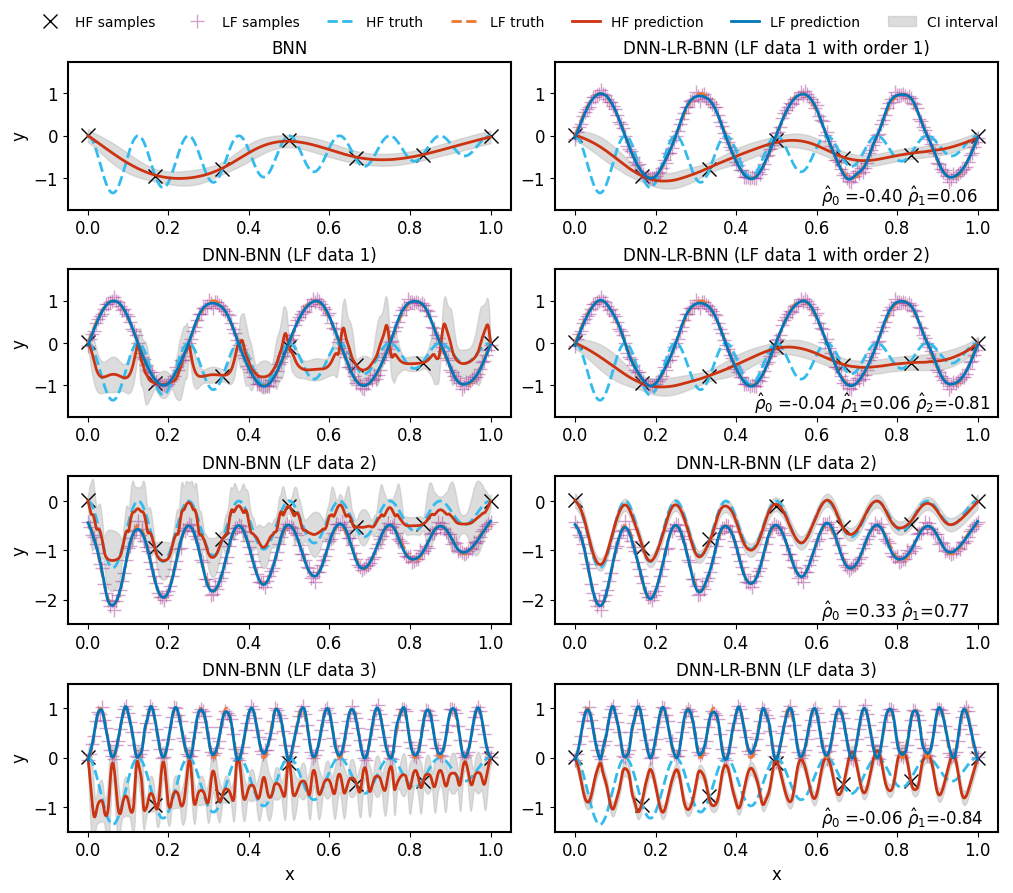

In [27]:
# plot the prediction of the models into one figure where the first row is the
# prediction of bnn (with one subfigure), and the second row is the prediction of sequential mf-bnn mf-dnn-bnn on lf1 (with two subfigures)
# the third row is the prediction of sequential mf-bnn mf-dnn-bnn on lf2 (with two subfigures)
# the forth row is the prediction of sequential mf-bnn mf-dnn-bnn on lf3  (with two subfigures)
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
# plot the prediction of bnn
axs[0, 0].plot(hf_samples, hf_responses, "kx",
               linewidth=2,
               markersize=10, label="HF samples")
axs[0, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)

axs[0, 0].plot(test_samples.numpy(),
               bnn_y,
               "-",
               color="#CC3311",
               linewidth=2,
               label="HF prediction",)

axs[0, 0].fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# axs[0, 0].legend()
axs[0, 0].set_title("BNN")

# plot the prediction of mf-dnn-bnn on lf1 with order1
axs[0, 1].plot(hf_samples, hf_responses, "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[0, 1].plot(lf_samples, lf1_responses,
               "+", color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples",)
axs[0, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
# plot the lf truth
axs[0, 1].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[0, 1].plot(test_samples.numpy(),
               mfdnnbnn_lf1_hy,  "-",
               color="#CC3311",
               linewidth=2,
               label="HF prediction",)
axs[0, 1].plot(
    test_samples.numpy(),
    mfdnnbnn_lf1_order_2_y,
    "-", color="#0077BB",
    linewidth=2,
    label="LF prediction",
)
axs[0, 1].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[0, 1].legend()
axs[0, 1].set_title("DNN-LR-BNN (LF data 1 with order 1)")


# plot the prediction of sequential mf-bnn on lf1
axs[1, 0].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[1, 0].plot(lf_samples, lf1_responses,  '+',
               color="#AA4499",
               linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples",)
axs[1, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[1, 0].plot(test_samples.numpy(), smf_bnn_lf1_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction",)
# plot the lf truth
axs[1, 0].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
#
axs[1, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    "-",
    color="#0077BB",
    linewidth=2,

    label="LF prediction"
)
axs[1, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[1, 0].legend()
axs[1, 0].set_title("DNN-BNN (LF data 1)")


# plot the prediction of mf-dnn-bnn on lf1
axs[1, 1].plot(hf_samples, hf_responses, "kx",
               linewidth=2,
               markersize=10,
               label="HF samples")
axs[1, 1].plot(lf_samples, lf1_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[1, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
# with lf order 2
axs[1, 1].plot(test_samples.numpy(), mfdnnbnn_lf1_order_2_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")
# plot the lf truth
axs[1, 1].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[1, 1].plot(
    test_samples.numpy(),
    mfdnnbnn_lf1_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
# with lf order 2
axs[1, 1].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_order_2_hy - 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    (mfdnnbnn_lf1_order_2_hy + 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[1, 1].legend()
axs[1, 1].set_title("DNN-LR-BNN (LF data 1 with order 2)")
# plot the prediction of sequential mf-bnn on lf2
axs[2, 0].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[2, 0].plot(lf_samples, lf2_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[2, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)


axs[2, 0].plot(test_samples.numpy(), smf_bnn_lf2_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction",)
# plot the lf truth
axs[2, 0].plot(
    test_samples.numpy(),
    test_lf2_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[2, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf2_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
axs[2, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf2_hy - 2 * smf_bnn_lf2_total_unc).reshape(-1),
    (smf_bnn_lf2_hy + 2 * smf_bnn_lf2_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",

)
# axs[2, 0].legend()
axs[2, 0].set_title("DNN-BNN (LF data 2)")

# plot the prediction of mf-dnn-bnn on lf2
axs[2, 1].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples")
axs[2, 1].plot(lf_samples, lf2_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[2, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)

axs[2, 1].plot(test_samples.numpy(), hy_proposed_lf2,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")
# plot the lf truth
axs[2, 1].plot(
    test_samples.numpy(),
    test_lf2_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
# plot the lf prediction
axs[2, 1].plot(
    test_samples.numpy(),
    lf2_y_proposed.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
# plot the uncertainty
axs[2, 1].fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf2 - 2 * total_unc_proposed_lf2).reshape(-1),
    (hy_proposed_lf2 + 2 * total_unc_proposed_lf2).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval"
)

# axs[2, 1].legend()
axs[2, 1].set_title("DNN-LR-BNN (LF data 2)")
# plot the prediction of sequential mf-bnn on lf3
axs[3, 0].plot(hf_samples, hf_responses,
               'kx', linewidth=2,
               markersize=10,
               label="HF samples")
axs[3, 0].plot(lf_samples, lf3_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[3, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[3, 0].plot(test_samples.numpy(), smf_bnn_lf3_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")

# plot the lf truth
axs[3, 0].plot(
    test_samples.numpy(),
    test_lf3_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[3, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf3_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"

)

axs[3, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf3_hy - 2 * smf_bnn_lf3_total_unc).reshape(-1),
    (smf_bnn_lf3_hy + 2 * smf_bnn_lf3_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# axs[3, 0].legend()
axs[3, 0].set_title("DNN-BNN (LF data 3)")

# plot the prediction of mf-dnn-bnn on lf3
axs[3, 1].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples")
axs[3, 1].plot(lf_samples, lf3_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[3, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[3, 1].plot(test_samples.numpy(), hy_proposed_lf3,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")


# plot the lf truth
axs[3, 1].plot(
    test_samples.numpy(),
    test_lf3_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
axs[3, 1].plot(
    test_samples.numpy(),
    lf3_y_proposed.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
axs[3, 1].fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf3 - 2 * total_unc_proposed_lf3).reshape(-1),
    (hy_proposed_lf3 + 2 * total_unc_proposed_lf3).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",

)
# axs[3, 1].legend()
axs[3, 1].set_title("DNN-LR-BNN (LF data 3)")
# set the axis labels x for the bottom row and y for the left column
for ii in range(4):
    for jj in range(2):
        if ii == 3:
            axs[ii, jj].set_xlabel("x", fontsize=12)
        if jj == 0:
            axs[ii, jj].set_ylabel("y", fontsize=12)
# set the line width of the axes
for ii in range(4):
    for jj in range(2):
        axs[ii, jj].spines["top"].set_linewidth(1.5)
        axs[ii, jj].spines["right"].set_linewidth(1.5)
        axs[ii, jj].spines["left"].set_linewidth(1.5)
        axs[ii, jj].spines["bottom"].set_linewidth(1.5)
        # font size of the axis
        axs[ii, jj].tick_params(axis="both", which="major", labelsize=12)

# set the limit of y for each row

for jj in range(2):
    axs[0, jj].set_ylim([-1.75, 1.75])
    axs[1, jj].set_ylim([-1.75, 1.75])
    axs[2, jj].set_ylim([-2.5, 0.5])
    axs[3, jj].set_ylim([-1.5, 1.5])
# set legende for the first subfigure  and put it outside the figure
axs[0, 1].legend(loc='upper left', bbox_to_anchor=(-1.2, 1.4), fontsize=10,
                 frameon=False, ncol=47)

# add beta values to the right subfigures
axs[0, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf1.beta[0].item(), mfdnnbnn_lf1.beta[1].item()),
    fontsize=12,
    transform=axs[0, 1].transAxes)
axs[1, 1].text(0.45, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f} $\hat \rho_2$={:0.2f}" .format(
    mfdnnbnn_lf1_order_2.beta[0].item(), mfdnnbnn_lf1_order_2.beta[1].item(), mfdnnbnn_lf1_order_2.beta[2].item()),
    fontsize=12,
    transform=axs[1, 1].transAxes)
axs[2, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf2.beta[0].item(), mfdnnbnn_lf2.beta[1].item()),
    fontsize=12,
    transform=axs[2, 1].transAxes)
axs[3, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf3.beta[0].item(), mfdnnbnn_lf3.beta[1].item()),
    fontsize=12,
    transform=axs[3, 1].transAxes)

# space of sub-figures
plt.subplots_adjust(wspace=0.1, hspace=0.4)
# save
plt.savefig("mf_dnn_bnn_known_noise.pdf", bbox_inches="tight", dpi=300)
plt.savefig("mf_dnn_bnn_known_noise.png", bbox_inches="tight", dpi=300)
plt.savefig("mf_dnn_bnn_known_noise.svg", bbox_inches="tight", dpi=300)
plt.show()